<a href="https://colab.research.google.com/github/siva-netizen/Abusive-Comment-Detection/blob/main/ToxicComment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df =pd.read_csv('/content/drive/MyDrive/Toxic-comment/train.csv')

In [ ]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
df.shape

(159571, 8)

In [ ]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [ ]:
df[df['toxic']==1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0


In [ ]:
df[df.columns[2:]].iloc[6]

,6
toxic,1
severe_toxic,1
obscene,1
threat,0
insult,1
identity_hate,0


Preprocessing

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
MAX_FEATURES = 200000 #NO.OF.WORDS IN THE VOCAB

In [ ]:
vectorizer = TextVectorization(
    max_tokens = MAX_FEATURES,
    output_sequence_length =1800, #max length
    output_mode='int'
)

In [ ]:
vectorizer.adapt(x.values)

In [ ]:
vectorizer('the hero')

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   2, 3468,    0, ...,    0,    0,    0])>

In [ ]:
vectorized_text = vectorizer(x.values)

In [ ]:
vectorized_text

<tf.Tensor: shape=(159571, 1800), dtype=int64, numpy=
array([[  645,    76,     2, ...,     0,     0,     0],
       [    1,    54,  2489, ...,     0,     0,     0],
       [  425,   441,    70, ...,     0,     0,     0],
       ...,
       [32445,  7392,   383, ...,     0,     0,     0],
       [    5,    12,   534, ...,     0,     0,     0],
       [    5,     8,   130, ...,     0,     0,     0]])>

**Tensorflow Data Pipeline**

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text,y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
len(dataset) #its a batch of 16

9974

In [ ]:
#train val test
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
len(train) , len(val) , len(test)

(6981, 1994, 997)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional,Dense,Embedding

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense

# Constants
MAX_FEATURES = 200000  # Number of words in the vocabulary
INPUT_LENGTH = 1800    # Maximum length of input sequences

# Model definition
model = Sequential()

# First layer: Embedding with explicit input shape
model.add(Embedding(input_dim=MAX_FEATURES + 1, output_dim=32, input_shape=(INPUT_LENGTH,)))

# Bidirectional LSTM
model.add(Bidirectional(LSTM(32, activation='tanh')))

# Feature Extractor
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))

# Final layer
model.add(Dense(6, activation='sigmoid'))

# Model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)              │ (None, 1800, 32)            │       6,400,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_7 (Bidirectional)      │ (None, 64)                  │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,483,494 (24.73 MB)

 Trainable params: 6,483,494 (24.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(loss='BinaryCrossentropy',optimizer='Adam')

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Metric to monitor (e.g., validation loss)
    patience=3,           # Number of epochs to wait before stopping if no improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)



In [ ]:
# Train the model with EarlyStopping
history = model.fit(
    train,
    epochs=10,
    validation_data=val,
    callbacks=[early_stopping]  # Pass EarlyStopping as a callback
)


Epoch 1/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 824s 117ms/step - loss: 0.0839 - val_loss: 0.0507
Epoch 2/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 844s 115ms/step - loss: 0.0462 - val_loss: 0.0422
Epoch 3/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 812s 116ms/step - loss: 0.0419 - val_loss: 0.0366
Epoch 4/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 804s 115ms/step - loss: 0.0370 - val_loss: 0.0343
Epoch 5/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 771s 110ms/step - loss: 0.0340 - val_loss: 0.0289
Epoch 6/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 801s 110ms/step - loss: 0.0300 - val_loss: 0.0275
Epoch 7/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 780s 112ms/step - loss: 0.0274 - val_loss: 0.0236
Epoch 8/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 813s 113ms/step - loss: 0.0241 - val_loss: 0.0212
Epoch 9/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 757s 108ms/step - loss: 0.0217 - val_loss: 0.0184
Epoch 10/10
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 800s 108ms/step - loss: 0.0189 - val_loss: 0.0154


In [ ]:
model.save('toxicCommentDetector.keras')

<Figure size 800x500 with 0 Axes>

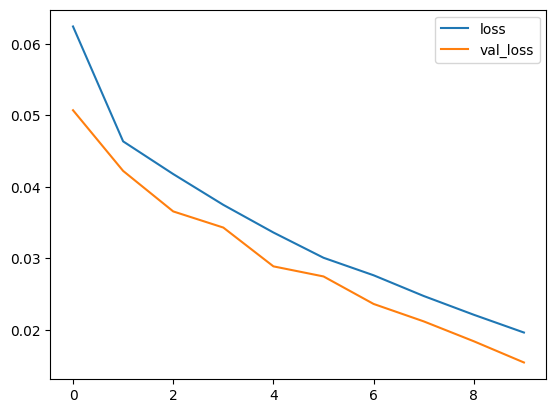

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 5))
pd.DataFrame(history.history).plot()
plt.show()

***MAKE PREDICTION***

In [ ]:
batch = test.as_numpy_iterator().next()

In [ ]:
input_text = vectorizer('you ball sucking  ! i am going to kill you')

In [ ]:
input_text

<tf.Tensor: shape=(1800,), dtype=int64, numpy=array([   7, 3043, 6026, ...,    0,    0,    0])>

In [ ]:
res = model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
res

array([[0.8941966 , 0.09808244, 0.6408496 , 0.18806024, 0.73843545,
        0.46211082]], dtype=float32)

In [ ]:
batch_x,batch_y = test.as_numpy_iterator().next()

In [ ]:
batch_y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
(model.predict(batch_x) >0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

***EVALUATE MODEL***

In [ ]:
from tensorflow.keras.metrics import Precision,Recall,CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  #unpack batch
  x_true,y_true = batch
  #prediction
  y_hat = model.predict(x_true)
  #flatten prediction
  y_true = y_true.flatten()
  y_hat = y_hat.flatten()

  pre.update_state(y_true,y_hat)
  re.update_state(y_true,y_hat)
  acc.update_state(y_true,y_hat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━

In [ ]:
print(f'Precision:{pre.result().numpy()},\nRecall:{re.result().numpy()},\nAccuracy:{acc.result().numpy()}')

Precision:0.9218706488609314,
Recall:0.9051415920257568,
Accuracy:0.5075225830078125


***TEST AND GRADIO***

In [ ]:
!pip install gradio jinja2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.4/321.4 kB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr

In [ ]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  result = model.predict(vectorized_comment)
  text = ''
  for idx,col in enumerate(df.columns[2:]):
    text +='{}:{}\n'.format(col,result[0][idx]>0.5)
  return text

In [ ]:
Interface = gr.Interface(
    fn=score_comment,  # The function to execute
    inputs=gr.Textbox(lines=2, placeholder='Comment to Score'),  # Use gr.Textbox
    outputs=gr.Text()  # Use gr.Text
)

In [ ]:
# Launch the interface
Interface.launch(share=True)

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c6e47b24ced7d96ca3.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
